# Failure Landscape Notebook (B-v2-step2-4)

목적: **Failure Landscape 관찰**

- 전체 요약(성공률, stage/error_type/signature 분포)
- task별 최신(trial 우선순위) 결과 요약
- docker 관련 signature만 필터링
- 실패 샘플 몇 개의 stderr / edit_script / diff를 빠르게 확인


In [1]:
# Cell 1) imports + run dir 설정
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

def pick_latest_run(runs_root: Path) -> Path:
    candidates = [p for p in runs_root.iterdir() if p.is_dir()]
    if not candidates:
        raise FileNotFoundError(f"No run dirs under: {runs_root}")
    return sorted(candidates, key=lambda p: p.name)[-1]

RUN_DIR = Path('..').resolve() / "runs"
if RUN_DIR.name == "runs":
    RUN_DIR = pick_latest_run(RUN_DIR)

RESULTS_CSV = RUN_DIR / "results.csv"
TRACES_DIR = RUN_DIR / "traces"

print("RUN_DIR =", RUN_DIR)
print("RESULTS_CSV exists?", RESULTS_CSV.exists())
print("TRACES_DIR exists?", TRACES_DIR.exists())

RUN_DIR = /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522
RESULTS_CSV exists? True
TRACES_DIR exists? True


In [2]:
# Cell 2) results.csv 로드 + 기본 전처리
df = pd.read_csv(RESULTS_CSV)
print("loaded:", RESULTS_CSV)
print("rows:", len(df), "cols:", len(df.columns))

# 타입/결측 정리
for c in ["success", "context_used", "edit_used", "edit_parse_ok", "diff_export_ok", "timeout"]:
    if c in df.columns:
        df[c] = df[c].astype("boolean")

# timestamp 파싱 (있을 때만)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# 편의 컬럼
df["task_key"] = df["task_id"].astype(str) + "::trial" + df["trial_id"].astype(str)

df.head()

loaded: /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522/results.csv
rows: 200 cols: 30


,task_id,trial_id,model,prompt_hash,taxonomy_version,success,stage,error_type,signature,returncode,...,format_ok,format_reason,apply_check_ok,apply_check_reason,patch_lines_added,patch_lines_removed,files_changed,timestamp,seed,task_key
0,astropy__astropy-12907,0,Qwen/Qwen2.5-Coder-7B-Instruct,1d006f36813d2fc095bc8da160e7e87abfd8d05ee8957d...,B-v2-step2-4,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,...,NaN,NaN,NaN,NaN,5,1,1,2026-02-23 12:15:22.541031,42,astropy__astropy-12907::trial0
1,astropy__astropy-14182,0,Qwen/Qwen2.5-Coder-7B-Instruct,323a3b727d26875c53e665ce8dcd10f792793ee5799a7a...,B-v2-step2-4,False,EDIT_PARSE,GEN_FAIL,invalid_edit_script,-1.0,...,NaN,NaN,NaN,NaN,0,0,0,2026-02-23 12:15:25.401072,42,astropy__astropy-14182::trial0
2,astropy__astropy-14365,0,Qwen/Qwen2.5-Coder-7B-Instruct,232a841813d672f784b09b1e96ec3c80e68dec2004a896...,B-v2-step2-4,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,...,NaN,NaN,NaN,NaN,7,1,1,2026-02-23 12:15:46.662068,42,astropy__astropy-14365::trial0
3,astropy__astropy-14995,0,Qwen/Qwen2.5-Coder-7B-Instruct,fd14cad64dd3edbd82b7592d7f25cd7092f88230923805...,B-v2-step2-4,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,...,NaN,NaN,NaN,NaN,2,1,1,2026-02-23 12:15:49.915310,42,astropy__astropy-14995::trial0
4,astropy__astropy-6938,0,Qwen/Qwen2.5-Coder-7B-Instruct,c5b32e42610f8f080a47c68fd74b8756f9c425cccd00e2...,B-v2-step2-4,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,...,NaN,NaN,NaN,NaN,0,0,0,2026-02-23 12:15:52.462452,42,astropy__astropy-6938::trial0


In [3]:
# Cell 3) 전체 요약
n = len(df)
succ = int(df["success"].fillna(False).sum()) if "success" in df.columns else 0
print(f"Total rows: {n}")
print(f"Success: {succ} ({succ/n*100:.2f}%)")

cols = ["taxonomy_version","model","seed","context_used","context_num_files","edit_used","edit_parse_ok","diff_export_ok"]
print("\n== Quick meta ==")
display(df[ [c for c in cols if c in df.columns] ].describe(include="all"))

Total rows: 200
Success: 0 (0.00%)

== Quick meta ==


,taxonomy_version,model,seed,context_used,context_num_files,edit_used,edit_parse_ok,diff_export_ok
count,200,200,200.0,200,200.000000,200,200,200
unique,1,1,NaN,1,NaN,1,2,2
top,B-v2-step2-4,Qwen/Qwen2.5-Coder-7B-Instruct,NaN,True,NaN,True,True,True
freq,200,200,NaN,200,NaN,200,181,147
mean,NaN,NaN,42.0,NaN,79.955000,NaN,NaN,NaN
std,NaN,NaN,0.0,NaN,0.451658,NaN,NaN,NaN
min,NaN,NaN,42.0,NaN,75.000000,NaN,NaN,NaN
25%,NaN,NaN,42.0,NaN,80.000000,NaN,NaN,NaN
50%,NaN,NaN,42.0,NaN,80.000000,NaN,NaN,NaN
75%,NaN,NaN,42.0,NaN,80.000000,NaN,NaN,NaN


In [4]:
# Cell 4) stage / error_type / signature 분포
def show_top_counts(col, topn=20):
    if col not in df.columns:
        print(f"[skip] missing column: {col}")
        return
    vc = df[col].fillna("NA").value_counts().head(topn)
    display(vc.to_frame("count"))

print("== stage =="); show_top_counts("stage")
print("== error_type =="); show_top_counts("error_type")
print("== signature =="); show_top_counts("signature", topn=30)

== stage ==


,count
stage,
EXEC,147
EDIT_APPLY,34
GEN,12
EDIT_PARSE,7


== error_type ==


,count
error_type,
EXEC_FAIL,147
APPLY_FAIL,34
GEN_FAIL,19


== signature ==


,count
signature,
docker_image_not_found,147
edit_apply_path_missing,32
llm_call_fail,12
invalid_edit_script,7
edit_apply_range_oob,2


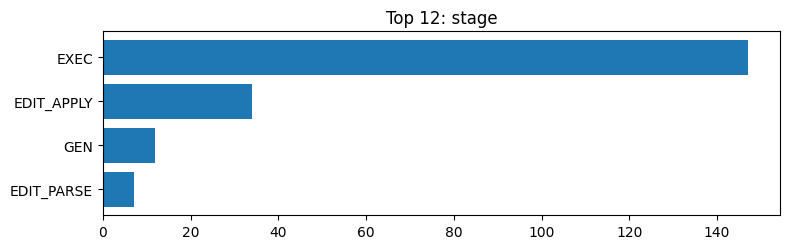

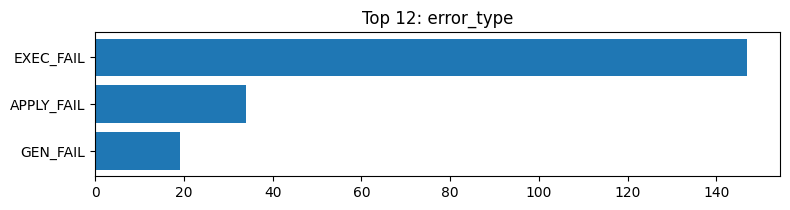

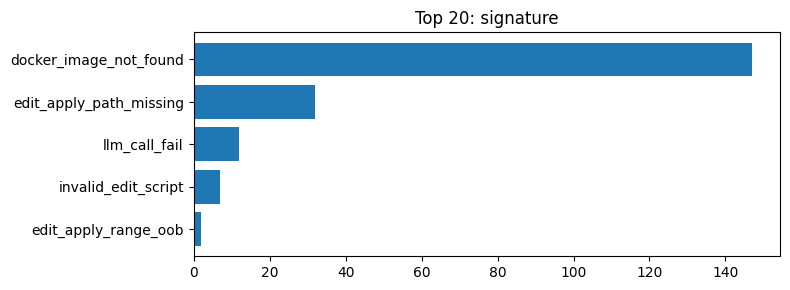

In [5]:
# Cell 5) 막대 그래프(분포) - matplotlib
def plot_counts(col, topn=15):
    if col not in df.columns:
        return
    vc = df[col].fillna("NA").value_counts().head(topn)[::-1]
    plt.figure(figsize=(8, 0.4*len(vc)+1))
    plt.barh(vc.index.astype(str), vc.values)
    plt.title(f"Top {topn}: {col}")
    plt.tight_layout()
    plt.show()

plot_counts("stage", topn=12)
plot_counts("error_type", topn=12)
plot_counts("signature", topn=20)

In [6]:
# Cell 6) task별 대표 결과(예: trial이 여러개면 '가장 마지막 trial' 또는 '가장 성공한 trial' 기준)
# 여기선 우선순위: success=True 우선, 그 다음 trial_id 큰 것 우선
df_sorted = df.copy()
df_sorted["success_rank"] = df_sorted["success"].fillna(False).astype(int)

df_best = (
    df_sorted.sort_values(["task_id", "success_rank", "trial_id"], ascending=[True, False, False])
             .drop_duplicates("task_id", keep="first")
             .drop(columns=["success_rank"])
)

print("Tasks:", df_best["task_id"].nunique())
succ_best = int(df_best["success"].fillna(False).sum())
print(f"Best-per-task success: {succ_best}/{len(df_best)} ({succ_best/len(df_best)*100:.2f}%)")
df_best[["task_id","trial_id","success","stage","error_type","signature","returncode","gen_elapsed_sec","elapsed_sec"]].head(20)

Tasks: 200
Best-per-task success: 0/200 (0.00%)


,task_id,trial_id,success,stage,error_type,signature,returncode,gen_elapsed_sec,elapsed_sec
0,astropy__astropy-12907,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.164019,1.605801
1,astropy__astropy-14182,0,False,EDIT_PARSE,GEN_FAIL,invalid_edit_script,-1.0,20.727043,0.533496
2,astropy__astropy-14365,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.574918,1.627457
3,astropy__astropy-14995,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,0.954870,1.552532
4,astropy__astropy-6938,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,0.684213,0.547453
5,astropy__astropy-7746,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.188316,1.486520
6,django__django-10914,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,0.688804,0.648402
7,django__django-10924,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.933854,1.552493
8,django__django-11001,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,1.071926,0.503612
9,django__django-11019,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,0.835758,1.631765


In [7]:
# Cell 6) task별 대표 결과(예: trial이 여러개면 '가장 마지막 trial' 또는 '가장 성공한 trial' 기준)
# 여기선 우선순위: success=True 우선, 그 다음 trial_id 큰 것 우선
df_sorted = df.copy()
df_sorted["success_rank"] = df_sorted["success"].fillna(False).astype(int)

df_best = (
    df_sorted.sort_values(["task_id", "success_rank", "trial_id"], ascending=[True, False, False])
             .drop_duplicates("task_id", keep="first")
             .drop(columns=["success_rank"])
)

print("Tasks:", df_best["task_id"].nunique())
succ_best = int(df_best["success"].fillna(False).sum())
print(f"Best-per-task success: {succ_best}/{len(df_best)} ({succ_best/len(df_best)*100:.2f}%)")
df_best[["task_id","trial_id","success","stage","error_type","signature","returncode","gen_elapsed_sec","elapsed_sec"]].head(20)

Tasks: 200
Best-per-task success: 0/200 (0.00%)


,task_id,trial_id,success,stage,error_type,signature,returncode,gen_elapsed_sec,elapsed_sec
0,astropy__astropy-12907,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.164019,1.605801
1,astropy__astropy-14182,0,False,EDIT_PARSE,GEN_FAIL,invalid_edit_script,-1.0,20.727043,0.533496
2,astropy__astropy-14365,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.574918,1.627457
3,astropy__astropy-14995,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,0.954870,1.552532
4,astropy__astropy-6938,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,0.684213,0.547453
5,astropy__astropy-7746,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.188316,1.486520
6,django__django-10914,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,0.688804,0.648402
7,django__django-10924,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,1.933854,1.552493
8,django__django-11001,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,-1.0,1.071926,0.503612
9,django__django-11019,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0,0.835758,1.631765


In [9]:
# Cell 7 (fix A) CSV만 사용: signature/returncode로 docker 계열 잡기
sig = df["signature"].fillna("")
docker_mask = (
    sig.str.contains("docker", case=False)
    | sig.isin(["docker_nonzero_returncode", "executor_exception"])  # 필요시 확장
    | (df.get("returncode", pd.Series([None]*len(df))).fillna(-999).isin([125, 126, 127]))
)

df_docker = df[docker_mask].copy()
print("Docker-related rows (csv-only):", len(df_docker))
display(df_docker[["task_id","trial_id","success","stage","error_type","signature","returncode"]].head(30))
display(df_docker["signature"].fillna("NA").value_counts().head(30).to_frame("count"))

Docker-related rows (csv-only): 147


,task_id,trial_id,success,stage,error_type,signature,returncode
0,astropy__astropy-12907,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
2,astropy__astropy-14365,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
3,astropy__astropy-14995,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
5,astropy__astropy-7746,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
7,django__django-10924,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
9,django__django-11019,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
11,django__django-11049,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
12,django__django-11099,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
13,django__django-11133,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0
14,django__django-11179,0,False,EXEC,EXEC_FAIL,docker_image_not_found,125.0


,count
signature,
docker_image_not_found,147


In [12]:
# Cell 8) traces/*.json 로드 (row와 join 가능하게)
# traces json은 파일명이 "<task_id>_trial<trial>.json" 포맷이므로 key로 매칭 가능
trace_rows = []
if TRACES_DIR.exists():
    for p in TRACES_DIR.glob("*.json"):
        try:
            obj = json.loads(p.read_text())
            # 최소 키
            task_id = obj.get("task_id")
            trial_id = obj.get("trial_id")
            trace_rows.append({
                "task_id": task_id,
                "trial_id": int(trial_id) if trial_id is not None else None,
                "trace_path": str(p),
                "issue_text": obj.get("issue_text"),
                "test_command_trace": obj.get("test_command"),
                "stderr_trace": obj.get("stderr"),
                "stdout_trace": obj.get("stdout"),
                "edit_script_trace": obj.get("edit_script"),
                "diff_trace": obj.get("diff"),
            })
        except Exception as e:
            print("Failed to read:", p, e)

df_tr = pd.DataFrame(trace_rows)
print("Trace rows:", len(df_tr))
df_tr.head()

Failed to read: /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522/traces/pytest-dev__pytest-5692_trial0.edit.json Expecting ',' delimiter: line 14 column 60 (char 408)
Failed to read: /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522/traces/astropy__astropy-14182_trial0.edit.json Expecting ',' delimiter: line 8 column 6 (char 175)
Failed to read: /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522/traces/pallets__flask-5063_trial0.edit.json Invalid \escape: line 67 column 56 (char 1646)
Failed to read: /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522/traces/django__django-12983_trial0.edit.json Invalid \escape: line 14 column 56 (char 376)
Failed to read: /home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260223_121522/traces/pylint-dev__pylint-5859_trial0.edit.json Invalid \escape: line 7 column 128

,task_id,trial_id,trace_path,issue_text,test_command_trace,stderr_trace,stdout_trace,edit_script_trace,diff_trace
0,None,NaN,/home/dibaeck/workspace/project_IR_sLM_MAS/run...,None,None,None,None,None,None
1,None,NaN,/home/dibaeck/workspace/project_IR_sLM_MAS/run...,None,None,None,None,None,None
2,django__django-12589,0.0,/home/dibaeck/workspace/project_IR_sLM_MAS/run...,None,echo 'No test command',Unable to find image 'swebench/sweb.eval.x86_6...,,"{\n ""edits"": [\n {\n ""op""...",diff --git a/tests/str/models.py b/tests/str/m...
3,scikit-learn__scikit-learn-11281,0.0,/home/dibaeck/workspace/project_IR_sLM_MAS/run...,None,echo 'No test command',Unable to find image 'swebench/sweb.eval.x86_6...,,"{\n ""edits"": [\n {\n ""op"": ""insert_af...",diff --git a/sklearn/mixture/base.py b/sklearn...
4,django__django-11742,0.0,/home/dibaeck/workspace/project_IR_sLM_MAS/run...,None,echo 'No test command',Unable to find image 'swebench/sweb.eval.x86_6...,,"{\n ""edits"": [\n {\n ""op""...",diff --git a/django/forms/fields.py b/django/f...


In [13]:
# Cell 9) results.csv 와 trace join (stderr/patch/edit_script 빠르게 보기)
df_join = df.merge(df_tr, on=["task_id","trial_id"], how="left")

# 확인: 어떤 row에 trace가 없는지
missing_trace = df_join["trace_path"].isna().sum()
print("Missing trace rows:", missing_trace)

df_join[["task_id","trial_id","success","stage","error_type","signature","trace_path"]].head(20)

Missing trace rows: 0


,task_id,trial_id,success,stage,error_type,signature,trace_path
0,astropy__astropy-12907,0,False,EXEC,EXEC_FAIL,docker_image_not_found,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
1,astropy__astropy-14182,0,False,EDIT_PARSE,GEN_FAIL,invalid_edit_script,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
2,astropy__astropy-14365,0,False,EXEC,EXEC_FAIL,docker_image_not_found,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
3,astropy__astropy-14995,0,False,EXEC,EXEC_FAIL,docker_image_not_found,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
4,astropy__astropy-6938,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
5,astropy__astropy-7746,0,False,EXEC,EXEC_FAIL,docker_image_not_found,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
6,django__django-10914,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
7,django__django-10924,0,False,EXEC,EXEC_FAIL,docker_image_not_found,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
8,django__django-11001,0,False,EDIT_APPLY,APPLY_FAIL,edit_apply_path_missing,/home/dibaeck/workspace/project_IR_sLM_MAS/run...
9,django__django-11019,0,False,EXEC,EXEC_FAIL,docker_image_not_found,/home/dibaeck/workspace/project_IR_sLM_MAS/run...


In [14]:
# Cell 10) 실패 샘플 몇 개 골라서 내용 보기 (stderr / edit_script / diff)
# 원하는 필터로 바꾸면 됨.
sample = df_join[(df_join["success"] == False)].head(5)

for _, r in sample.iterrows():
    print("="*120)
    print("task:", r["task_id"], "trial:", r["trial_id"])
    print("stage:", r.get("stage"), "error_type:", r.get("error_type"), "sig:", r.get("signature"))
    print("returncode:", r.get("returncode"))
    print("\n--- test_command ---")
    print(r.get("test_command_trace") or r.get("test_command") or "")
    print("\n--- stderr (first 800 chars) ---")
    s = (r.get("stderr_trace") or r.get("stderr") or "")
    print(s[:800])
    print("\n--- edit_script (first 800 chars) ---")
    es = (r.get("edit_script_trace") or "")
    print(es[:800])
    print("\n--- diff (first 800 chars) ---")
    d = (r.get("diff_trace") or r.get("diff") or "")
    print(d[:800])

task: astropy__astropy-12907 trial: 0
stage: EXEC error_type: EXEC_FAIL sig: docker_image_not_found
returncode: 125.0

--- test_command ---
echo 'No test command'

--- stderr (first 800 chars) ---
Unable to find image 'swebench/sweb.eval.x86_64:latest' locally
docker: Error response from daemon: pull access denied for swebench/sweb.eval.x86_64, repository does not exist or may require 'docker login'

Run 'docker run --help' for more information


--- edit_script (first 800 chars) ---
{
    "edits": [
        {
            "op": "insert_after",
            "path": "astropy/modeling/core.py",
            "line": 100,
            "text": "def _is_separable(self, model):\n    if isinstance(model, CompoundModel):\n        return all(self._is_separable(submodel) for submodel in model.models)\n    else:\n        return super()._is_separable(model)"
        }
    ]
}

--- diff (first 800 chars) ---
diff --git a/astropy/modeling/core.py b/astropy/modeling/core.py
index da4352cb0c..b1db887f12 10

In [16]:
# Cell 11) "invalid_edit_script"만 모아서 원인 분류 (안전 버전)

def col_or_empty(d, col):
    if col in d.columns:
        return d[col]
    return pd.Series([""] * len(d), index=d.index)

# df_join이 있으면 df_join, 없으면 df 사용
base_df = df_join if "df_join" in globals() else df

sig_col = col_or_empty(base_df, "signature").fillna("")
parse_reason_col = col_or_empty(base_df, "edit_parse_reason").fillna("")

mask = (sig_col == "invalid_edit_script") | (parse_reason_col == "invalid_edit_script")
bad = base_df[mask].copy()

print("invalid_edit_script rows:", len(bad))

if len(bad):
    display(
        bad[[
            c for c in [
                "task_id","trial_id","stage","error_type",
                "signature","edit_parse_reason","diff_export_reason"
            ] if c in bad.columns
        ]].head(30)
    )

    # stderr는 trace 기준으로 우선 사용
    stderr_trace_col = col_or_empty(bad, "stderr_trace")
    stderr_csv_col = col_or_empty(bad, "stderr")

    bad["stderr_head"] = (
        stderr_trace_col.fillna(stderr_csv_col)
        .fillna("")
        .str.replace("\n"," ", regex=False)
        .str.slice(0,160)
    )

    display(
        bad["stderr_head"]
        .value_counts()
        .head(20)
        .to_frame("count")
    )

invalid_edit_script rows: 7


,task_id,trial_id,stage,error_type,signature,edit_parse_reason,diff_export_reason
1,astropy__astropy-14182,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...
45,django__django-12983,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...
149,pallets__flask-5063,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...
158,pydata__xarray-4248,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...
161,pylint-dev__pylint-5859,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...
166,pylint-dev__pylint-7993,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...
174,pytest-dev__pytest-5692,0,EDIT_PARSE,GEN_FAIL,invalid_edit_script,invalid_edit_script,empty_generated_diff:EDIT_PARSE:invalid_edit_s...


,count
stderr_head,
"Expecting ',' delimiter: line 8 column 6 (char 175)",1
Invalid \escape: line 14 column 56 (char 376),1
Invalid \escape: line 67 column 56 (char 1646),1
Invalid \escape: line 7 column 198 (char 305),1
Invalid \escape: line 7 column 1282 (char 1412),1
Invalid \escape: line 8 column 41 (char 180),1
"Expecting ',' delimiter: line 14 column 60 (char 408)",1
